### [View with interactive plots with nbviewer](https://nbviewer.org/github/NVE/TuLiPa/blob/master/demos/Demo%204%20-%20Deterministic%20hydro.ipynb)

In [1]:
using DataFrames, Plots, Statistics, JSON, Clp
plotlyjs()
include(joinpath(dirname(pwd()),"src/TuLiPa.jl")); # using Dates, JuMP, HiGHS, CSV, Clustering

WebIO._IJuliaInit()

# Demo 4 - Deterministic hydro

Demo 4 optimizes the Aurland watercourse against an exogen area. NVEs dataset for the hydropower system in 2022 is open, but we have not published datasets for 2025/2030/2040/2050 since it would reveal investment plans. The dataset exist in several formats:
- Aggregated (for Res and RoR) production capacity, reservoir capacity, inflow and inflow profiles per price areas from https://www.nve.no/energi/analyser-og-statistikk/vaerdatasett-for-kraftsystemmodellene/
- Detailed watercourse descriptions from https://www.nve.no/energi/energisystem/vannkraft/modell-av-det-norske-vannkraftsystemet/. The dataset exist in two DETD-formats (per EMPS area (also includes rest modules for small-scale hydro) or per watercourse), and simplified in an Excel-format. The dataset used in this demo is derived from the excel-format with some differences: 
    - Every water balance has its own module (i.e. a module with both regulated and unregulated inflow is split into two modules). 
    - It has pq-kurves and environmental restrictions
- The inflow series for the detailed dataset can be found at https://www.nve.no/vann-og-vassdrag/hydrologiske-data/historiske-data/historiske-vannfoeringsdata-til-produksjonsplanlegging/. 

The price for the exogen area is generated in 1.6 in Demo 2.

Special model objects are used for the detailed hydropower modelling. These are SoftBound (for reservoir, release or bypass restrictions) and SegmentedArrow (for release PQ-kurves).

## Function to add boundary condition for storages

In [2]:
# The hydropower storages in the dataset needs boundary conditions for the state variables
function addStartEqualStopAllStorages!(modelobjects)
    for obj in values(modelobjects)
        if obj isa BaseStorage
            trait = StartEqualStop(obj)
            modelobjects[getid(trait)] = trait
        end
    end
end

addStartEqualStopAllStorages! (generic function with 1 method)

## Solve and plot results for watercourse scenarios

We solve the Aurland watercourse deterministically for 10 scenarios that last 5 years each, against a price series generated in 1.7 in Demo 2. The hydro horizon is with a weekly resolution and the power horizon with a daily resolution.

Results:
- We get expected behaviour with water being stored from the spring flood to the winter, and most production in the winter.
- Releases, pumping, spill, bypass and storages are restricted by their upper capacity, and environmental restrictions.
- For pumped hydro storage there is not production and pumping at the same time.
- With these horizons the problems are very fast to build, update, solve and plot. Other setting not shown in this demo:
    - With a hourly resolution in the power horizon, it takes around 1 s to build the problem, 0.2 s to update each scenario and 2 s to solve each scenario. 
    - The HiGHS dual simplex solver is much faster than the interior-point method solver.

#### Most of the code below is for collecting and plotting results. Scroll down for plots.

  2.596093 seconds (1.66 M allocations: 109.748 MiB, 2.53% gc time, 98.81% compilation time)
  1.063422 seconds (573.91 k allocations: 30.667 MiB, 3.47% gc time, 98.80% compilation time)
  0.144976 seconds
Objective value in scenario 1: -9127.497735085804
  0.010558 seconds (152.86 k allocations: 3.002 MiB)
  0.069109 seconds
Objective value in scenario 2: -9086.648982406728
  0.011784 seconds (152.86 k allocations: 3.002 MiB)
  0.046529 seconds
Objective value in scenario 3: -8918.611593170908
  0.011418 seconds (152.86 k allocations: 3.002 MiB)
  0.064144 seconds
Objective value in scenario 4: -8270.266380574914
  0.011200 seconds (152.86 k allocations: 3.002 MiB)
  0.054761 seconds
Objective value in scenario 5: -9025.465823231867
  0.010019 seconds (152.86 k allocations: 3.002 MiB)
  0.056693 seconds
Objective value in scenario 6: -9754.36430184148
  0.009850 seconds (152.86 k allocations: 3.002 MiB)
  0.050175 seconds
Objective value in scenario 7: -9764.861290964578
  0.009452 se

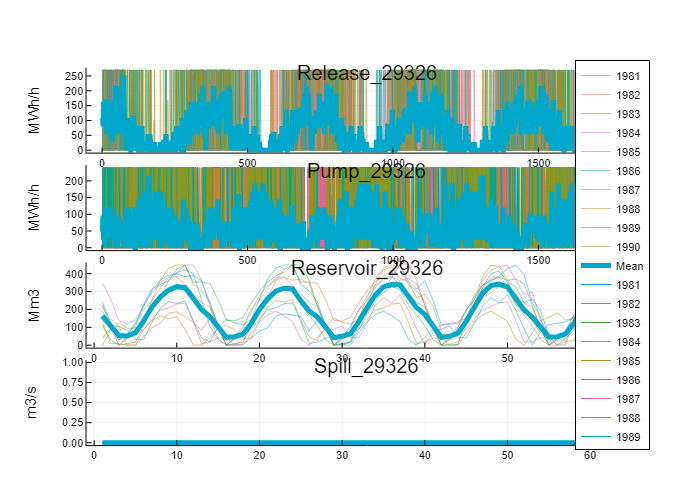

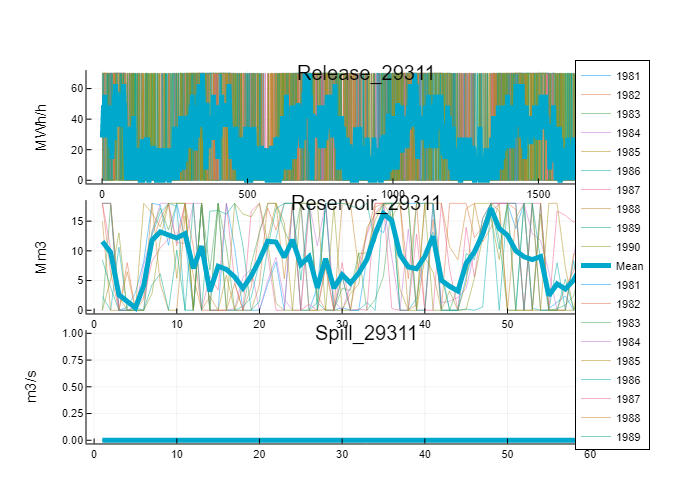

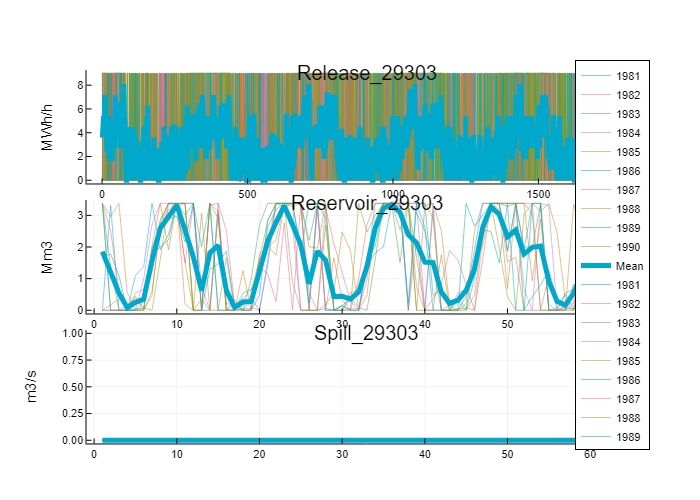

LoadError: AssertionError: length(l) == 1

In [3]:
# Make list of scenarios
function getscenarios(dt; years)
    [TwoTime(getisoyearstart(dt), getisoyearstart(yr)) for yr in years]
end

function runwatercourse()
    
    # Read dataelements from json-files
    sti_dynmodelldata = "dataset_vassdrag"
    price = JSON.parsefile("priceDMK.json")
    detdprice = getelements(price);
    tidsserie = JSON.parsefile(joinpath(sti_dynmodelldata, "tidsserier_detd.json"))
    detdseries = getelements(tidsserie, sti_dynmodelldata);
    dst = JSON.parsefile(joinpath(sti_dynmodelldata, "dataset_detd_AURLAND_H.json"))
    detdstructure = getelements(dst);

    elements = vcat(detdseries,detdprice,detdstructure)
    
    # Add horizons to the dataset
    scenarioyearstart = 1981
    scenarioyearstop = 1996 # price series only goes to 1995
    hydro_horizon = SequentialHorizon(13*5, Hour(168*4))
    power_horizon = SequentialHorizon(7*52*5, Hour(24))
    push!(elements, getelement(COMMODITY_CONCEPT, "BaseCommodity", "Power", 
            (HORIZON_CONCEPT, power_horizon)))
    push!(elements, getelement(COMMODITY_CONCEPT, "BaseCommodity", "Hydro", 
            (HORIZON_CONCEPT, hydro_horizon)))
    
    # Select which scenarios to include from the time-series
    push!(elements, getelement(TIMEPERIOD_CONCEPT, "ScenarioTimePeriod", "ScenarioTimePeriod", 
            ("Start", getisoyearstart(scenarioyearstart)), ("Stop", getisoyearstart(scenarioyearstop))))
    
    # Add an exogenous price area that the plants and pumps can interact with. All units are in NO5.
    push!(elements, getelement(BALANCE_CONCEPT, "ExogenBalance", "PowerBalance_NO5", 
            (COMMODITY_CONCEPT, "Power"),
            (PRICE_CONCEPT, "PriceDMK")))
    
    # Generate modelobjects from dataelements and add boundary conditions to storages
    modelobjects = getmodelobjects(elements)
    addStartEqualStopAllStorages!(modelobjects)
    
    # List all plants, pumps, bypasses, spills and storages - and plant arrows to calculate eneq
    plants = []
    pumps = []
    bypasspills = []
    storages = []
    
    plantarrows = []
    demandarrows = []
    
    for obj in values(modelobjects)
        if obj isa BaseFlow
            for a in getarrows(obj)
                balance = getbalance(a)
                if balance isa ExogenBalance
                    if isingoing(a)
                        push!(plants,obj)
                        push!(plantarrows,a)
                    else
                        push!(pumps,obj)
                        push!(demandarrows,a)
                    end
                    @goto skip
                end
            end
            push!(bypasspills, obj)
        end
        @label skip
        if obj isa BaseStorage
            push!(storages,obj)
        end
    end
    
    # Periods in horizons
    numperiods_power = getnumperiods(power_horizon)
    numperiods_hydro = getnumperiods(hydro_horizon)
    
    # Timefactors to convert results regardless of horizon (Mm3 -> m3/s and GWh -> MWh/h)
    timedelta_power = gettimedelta(power_horizon,1)
    timedelta_hydro = gettimedelta(hydro_horizon,1)
    timefactor_power = getduration(timedelta_power)/Millisecond(3600000000)
    timefactor_hydro = getduration(timedelta_hydro)/Millisecond(1e9)
    
    # Choose scenarios model year 2021 and weather scenarios starting from 1981/1982/1983 etc...
    scenarios = getscenarios(2021; years=1981:1990)

    # Preallocate matrices to store results
    production = zeros(numperiods_power, length(scenarios), length(plants))
    consumption = zeros(numperiods_power, length(scenarios), length(pumps))
    hydrolevels = zeros(numperiods_hydro, length(scenarios), length(storages))
    bypasspill = zeros(numperiods_hydro, length(scenarios), length(bypasspills))
    
    # Initialize problem, update for chosen scenario and collect results
    @time prob = HiGHS_Prob(collect(values(modelobjects)))
    
    for (s, t) in enumerate(scenarios)
        scenyear = string(getisoyear(getscenariotime(t)))

        @time update!(prob, t)
        
        @time solve!(prob)
        println("Objective value in scenario $(s): ", getobjectivevalue(prob))
        
        # Store results for each scenario
        for j in 1:numperiods_power
            
            # Production
            for i in 1:length(plants)
                arrow = plantarrows[i]
                if arrow isa SegmentedArrow # PQ-kurve
                    production[j, s, i] = 0
                    for k in 1:length(getconversions(arrow))
                        segmentid = getsegmentid(arrow, k)
                        horizon = gethorizon(arrow)
                        conversionparam = getconversions(arrow)[k]
                        querytime = getstarttime(horizon, j, t)
                        querydelta = gettimedelta(horizon, j)
                        conversionvalue = getparamvalue(conversionparam, querytime, querydelta) # eneq at segment
                        production[j, s, i] += getvarvalue(prob, segmentid, j)*conversionvalue/timefactor_power
                    end
                else
                    horizon = gethorizon(arrow)
                    conversionparam = _getcontributionparam(arrow)
                    querytime = getstarttime(horizon, j, t)
                    querydelta = gettimedelta(horizon, j)
                    conversionvalue = getparamvalue(conversionparam, querytime, querydelta) # eneq
                    production[j, s, i] = getvarvalue(prob, getid(plants[i]), j)*conversionvalue/timefactor_power
                end
            end
            
            # Pump consumption
            for i in 1:length(pumps)
                arrow = demandarrows[i]
                horizon = gethorizon(arrow)
                conversionparam = _getcontributionparam(arrow)
                querytime = getstarttime(horizon, j, t)
                querydelta = gettimedelta(horizon, j)
                conversionvalue = getparamvalue(conversionparam, querytime, querydelta) # eneq
                consumption[j, s, i] = getvarvalue(prob, getid(pumps[i]), j)*conversionvalue/timefactor_power
            end
        end
        for j in 1:numperiods_hydro
            
            # Storage levels
            for i in 1:length(storages) 
                hydrolevels[j, s, i] = getvarvalue(prob, getid(storages[i]), j)
            end
            
            # Bypass and spill
            for i in 1:length(bypasspills) 
                bypasspill[j, s, i] = getvarvalue(prob, getid(bypasspills[i]), j)/timefactor_hydro
            end
        end
    end
    
    # Plot list of yearly mean production and demand for each supply/demand
    supplynames = [getinstancename(getid(plant)) for plant in plants]
    demandnames = [getinstancename(getid(pump)) for pump in pumps]
    meandemand = dropdims(mean(consumption[:,:,:],dims=(1,2)),dims=(1,2))
    meanproduction = dropdims(mean(production[:,:,:],dims=(1,2)),dims=(1,2))
    supplydf = sort(DataFrame(Supplyname = supplynames, Yearly_supply_GWh = meanproduction*8.76),[:Yearly_supply_GWh], rev = true)
    demanddf = sort(DataFrame(Demandname = demandnames, Yearly_demand_GWh = meandemand*8.76),[:Yearly_demand_GWh], rev = true)
    supplydf[!,:ID] = collect(1:length(supplynames))
    demanddf[!,:ID] = collect(1:length(demandnames))
    joineddf = select!(outerjoin(supplydf,demanddf;on=:ID),Not(:ID))
    show(joineddf,allcols=true, allrows=true)

    # Start of weather scenario for plot labels
    scenyears = reshape([string(getisoyear(getscenariotime(t))) for t in scenarios],1,length(scenarios))
    
    # Useful lists of modelobjects
    mainobjects = getmainmodelobjects(modelobjects)
    balanceflows = getbalanceflows(modelobjects)
    
    # Preallocate to store environmental restrictions
    softvalues_power = zeros(numperiods_power)
    softvalues_hydro = zeros(numperiods_hydro)
    
    # For each plant plot its production, and connected pumping, storage, spill and bypass
    for i in 1:length(plants)
        
        # Plot production
        plant = plants[i]
        plot1 = plot(sum(production[:,:,i],dims=3),label=scenyears, linewidth=0.5, ylabel="MWh/h", title=getinstancename(getid(plant)))
        plot!(plot1, mean(sum(production[:,:,i],dims=3),dims=2),name="Mean", linewidth=5, thickness_scaling = 1)
        
        # Release restrictions
        if haskey(mainobjects,plant)
            for trait in mainobjects[plant]
                if trait isa BaseSoftBound
                    # Convert release restriction to MWh/h to plot it together with the production
                    # TODO: Now assume constant conversion
                    arrow = plantarrows[i] 
                    horizon = gethorizon(arrow)
                    dummytime = ConstantTime()
                    dummydelta = MsTimeDelta(Hour(1))
                    
                    if arrow isa SegmentedArrow # PQ-curve
                        # TODO: Use mean energy equivalent rather than calculating it
                        conversionvalue = 0
                        capacitytotal = 0
                        for k in 1:length(getconversions(arrow))
                            conversionparam = getconversions(arrow)[k]
                            capacityparam = getcapacities(arrow)[k]
                            capacityvalue = getparamvalue(capacityparam, dummytime, dummydelta)
                            if getparamvalue(conversionparam, dummytime, dummydelta) > 0
                                conversionvalue += getparamvalue(conversionparam, dummytime, dummydelta)*capacityvalue
                                capacitytotal += capacityvalue
                            end
                        end
                        conversionvalue /= capacitytotal
                    else
                        conversionparam = getconversion(arrow)
                        conversionvalue = getparamvalue(conversionparam, dummytime, dummydelta)
                    end
                            
                    for j in 1:numperiods_power
                        softvalues_power[j] = getrhsterm(prob, getleid(trait), getsoftcapid(trait), j)*conversionvalue/timefactor_power
                    end
                    if sum(softvalues_power) > 0
                        plot!(plot1, softvalues_power,name="MaxSoftCap")
                    elseif sum(softvalues_power) < 0
                        plot!(plot1, softvalues_power*-1,name="MinSoftCap")
                    end
                end
            end
        end
        allplots = []
        push!(allplots,plot1)
        
        # Pumped power - if arrows of plant and pump is connected to the three same balances
        arrows = getarrows(plant)
        balances = []
        if length(arrows) == 3
            for arrow in arrows
                push!(balances, getbalance(arrow))
            end
        end
        
        for (i, pump) in enumerate(pumps)
            arrows = getarrows(pump)
            if length(arrows) == 3
                if (getbalance(arrows[1]) in balances) & (getbalance(arrows[2]) in balances) & (getbalance(arrows[3]) in balances)
                    
                    # Plot pump demand
                    plot4 = plot(sum(consumption[:,:,i],dims=3),label=scenyears, ylabel="MWh/h", title=getinstancename(getid(pump)))
                    plot!(plot4, mean(sum(consumption[:,:,i],dims=3),dims=2),name="Mean", linewidth=5, thickness_scaling = 1)
                    push!(allplots, plot4)
                    filter!(e -> e != pump, pumps)
                end
            end
        end 
        
        # Main reservoir - search upwards in the watercourse for reservoir connected to the plant
        arrows = getarrows(plant)
        for arrow in arrows
            if !isingoing(arrow)
                prodbalance = getbalance(arrow) # first identify water balance over plant
                
                # plants with only regulated inflow have one storage directly over plant / water balance (dependant on dataset)
                for (i, storage) in enumerate(storages) 
                    if getbalance(storage) == prodbalance
                        
                        # Plot identified reservoir
                        plot2 = plot(sum(hydrolevels[:,:,i],dims=3),label=scenyears, linewidth=0.5, ylabel="Mm3", title=getinstancename(getid(storage)))
                        plot!(plot2, mean(sum(hydrolevels[:,:,i],dims=3),dims=2),name="Mean", linewidth=5, thickness_scaling = 1)
                        
                        # Plot reservoir restrictions
                        if haskey(mainobjects,storage)
                            for trait in mainobjects[storage]
                                if trait isa BaseSoftBound
                                    for j in 1:numperiods_hydro
                                        softvalues_hydro[j] = getrhsterm(prob, getleid(trait), getsoftcapid(trait), j)
                                    end
                                    if sum(softvalues_hydro) > 0
                                        plot!(plot2, softvalues_hydro, name="MaxSoftCap")
                                    elseif sum(softvalues_hydro) < 0
                                        plot!(plot2, softvalues_hydro*-1, name="MinSoftCap")
                                    end
                                end
                            end
                        end

                        push!(allplots,plot2)
                        @goto escape_label
                    end
                end
                
                # plants with unregulated and regulated inflow have one storage two waterbalances up (dependant on dataset)
                for flow in getbalanceflows(modelobjects)[prodbalance]
                    if !(flow in pumps) & !(flow in plants)
                        for arrow in getarrows(flow)
                            if isingoing(arrow) & (getbalance(arrow) == prodbalance)
                                for arrow1 in getarrows(flow)
                                    if !isingoing(arrow1)
                                        storagebalance = getbalance(arrow1)
                                        for storage in storages
                                            if getbalance(storage) == storagebalance
                                                
                                                # Plot identified reservoir
                                                l = findall(x -> x == storage, storages)
                                                @assert length(l) == 1
                                                plot2 = plot(sum(hydrolevels[:,:,l[1]],dims=3),label=scenyears, linewidth=0.5, ylabel="Mm3", title=getinstancename(getid(obj)))
                                                plot!(plot2, mean(sum(hydrolevels[:,:,l[1]],dims=3),dims=2),name="Mean", linewidth=5, thickness_scaling = 1)
                                                
                                                # Plot reservoir restrictions
                                                if haskey(mainobjects,obj)
                                                    for trait in mainobjects[obj]
                                                        if trait isa BaseSoftBound
                                                            for j in 1:numperiods_hydro
                                                                softvalues_hydro[j] = getrhsterm(prob, getleid(trait), getsoftcapid(trait), j)
                                                            end
                                                            if sum(softvalues_hydro) > 0
                                                                plot!(plot2, softvalues_hydro, name="MaxSoftCap")
                                                            elseif sum(softvalues_hydro) < 0
                                                                plot!(plot2, softvalues_hydro*-1, name="MinSoftCap")
                                                            end
                                                        end
                                                    end
                                                end
                                                
                                                push!(allplots,plot2)
                                                @goto escape_label
                                            end
                                        end
                                    end
                                end
                            end
                        end
                    end
                end
            end
        end
        @label escape_label
        
        # Bypasses and spills
        arrows = getarrows(plant)
        for arrow in arrows
            if !isingoing(arrow)
                prodbalance = getbalance(arrow) # first identify water balance over plant (dependant on dataset)
                
                # bypass/spill from first water balance over plant
                for flow in getbalanceflows(modelobjects)[prodbalance]
                    if !(flow in plants) & !(flow in pumps)
                        for arrow1 in getarrows(flow)
                            if !isingoing(arrow1) & (getbalance(arrow1) == prodbalance)

                                # Plot identified bypass/spill
                                l = findall(x -> x == flow, bypasspills)
                                @assert length(l) == 1
                                plot3 = plot(sum(bypasspill[:,:,l[1]],dims=3),label=scenyears, linewidth=0.5, ylabel="m3/s", title=getinstancename(getid(flow)))
                                plot!(plot3, mean(sum(bypasspill[:,:,l[1]],dims=3),dims=2),name="Mean", linewidth=5, thickness_scaling = 1)

                                # Plot bypass restrictions
                                if haskey(mainobjects,flow)
                                    for trait in mainobjects[flow]
                                        if trait isa BaseSoftBound
                                            for j in 1:numperiods_hydro
                                                softvalues_hydro[j] = getrhsterm(prob, getleid(trait), getsoftcapid(trait), j)/timefactor_hydro
                                            end
                                            if sum(softvalues_hydro) > 0
                                                plot!(plot3, softvalues_hydro,name="MaxSoftCap")
                                            elseif sum(softvalues_hydro) < 0
                                                plot!(plot3, softvalues_hydro*-1,name="MinSoftCap")
                                            end
                                        end
                                    end
                                end
                                push!(allplots,plot3)
                            end
                        end
                    end
                end
                
                # if storage connected to waterbalance, don't search further up
                for storage in storages 
                    if getbalance(storage) == prodbalance
                        @goto escape_label1
                    end
                end
                
                # bypass/spill from second water balance over plant (dependant on dataset)
                for flow in getbalanceflows(modelobjects)[prodbalance]
                    if !(flow in pumps) & !(flow in plants)
                        for arrow in getarrows(flow)
                            if isingoing(arrow) & (getbalance(arrow) == prodbalance)
                                for arrow in getarrows(flow)
                                    if !isingoing(arrow)
                                        storagebalance = getbalance(arrow)
                                        for storage in storages
                                            if getbalance(storage) == storagebalance # identified second water balance over plant
                                                for flow1 in getbalanceflows(modelobjects)[storagebalance]
                                                    if !(flow1 == flow)
                                                        for arrow1 in getarrows(flow1)
                                                            if !isingoing(arrow1) & (getbalance(arrow1) == storagebalance)

                                                                # Plot identified bypass/spill
                                                                l = findall(x -> x == flow1, bypasspills)
                                                                @assert length(l) == 1
                                                                plot3 = plot(sum(bypasspill[:,:,l[1]],dims=3),label=scenyears, linewidth=0.5, ylabel="m3/s", title=getinstancename(getid(flow)))
                                                                plot!(plot3, mean(sum(bypasspill[:,:,l[1]],dims=3),dims=2),name="Mean", linewidth=5, thickness_scaling = 1)

                                                                # Plot bypass restrictions
                                                                if haskey(mainobjects,flow1)
                                                                    for trait in mainobjects[flow1]
                                                                        if trait isa BaseSoftBound
                                                                            for j in 1:numperiods_hydro
                                                                                softvalues_hydro[j] = getrhsterm(prob, getleid(trait), getsoftcapid(trait), j)/timefactor_hydro
                                                                            end
                                                                            if sum(softvalues_hydro) > 0
                                                                                plot!(plot3, softvalues_hydro,name="MaxSoftCap")
                                                                            elseif sum(softvalues_hydro) < 0
                                                                                plot!(plot3, softvalues_hydro*-1,name="MinSoftCap")
                                                                            end
                                                                        end
                                                                    end
                                                                end
                                                                push!(allplots,plot3)
                                                            end
                                                        end
                                                    end
                                                end
                                            end
                                        end
                                    end
                                end
                            end
                        end
                    end
                end
            end
        end
        @label escape_label1
        display(plot(allplots...,layout=(length(allplots),1),size=(900,300*length(allplots))))
    end
    
    # Remaining pumps
    for i in 1:length(pumps)
        plot5 = plot(sum(consumption[:,:,i],dims=3),label=scenyears, title=getinstancename(getid(pumps[i])), size=(900,300))
        plot!(plot5, mean(sum(consumption[:,:,i],dims=3),dims=2),name="Mean", linewidth=5, thickness_scaling = 1)
        display(plot5)
    end
end

runwatercourse()